In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nibabel as nib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Test

In [54]:
excel_path = "data_processed/participants.xlsx"
data_dir = "data_processed"

In [55]:
df = pd.read_excel(excel_path)
df

,No.,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,1,44.2,control,m,sub-BrainAge000019,ABIDE/Caltech
1,2,39.3,control,m,sub-BrainAge000020,ABIDE/Caltech
2,3,42.5,control,m,sub-BrainAge000021,ABIDE/Caltech
3,4,19.7,control,m,sub-BrainAge000022,ABIDE/Caltech
4,5,20.0,control,f,sub-BrainAge000023,ABIDE/Caltech
...,...,...,...,...,...,...
4943,4944,66.0,control,f,sub-BrainAge023209,RocklandSample
4944,4945,69.0,control,m,sub-BrainAge023210,RocklandSample
4945,4946,23.0,control,m,sub-BrainAge023211,RocklandSample
4946,4947,54.0,control,f,sub-BrainAge023212,RocklandSample


In [56]:
class BrainAgeDataset(Dataset):
    def __init__(self, excel_path, root_dir, max_samples=None):
        df = pd.read_excel(excel_path)
        self.data = df[["subject_id", "subject_age"]]
        if max_samples:
            self.data = self.data.iloc[:max_samples].copy()
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id = self.data.iloc[idx]["subject_id"]
        age = self.data.iloc[idx]["subject_age"]

        img_path = os.path.join(self.root_dir, subject_id, "anat", f"{subject_id}_T1w_processed.nii.gz")
        img = nib.load(img_path).get_fdata().astype(np.float32)
        img = np.expand_dims(img, axis=0)  # Shape: (1, H, W, D)
        img = torch.from_numpy(img)

        return img, torch.tensor(age, dtype=torch.float32)

In [59]:
dataset = BrainAgeDataset(excel_path, data_dir, max_samples=1500)

In [60]:
print("Total samples:", len(dataset))

Total samples: 1500


In [61]:
sample_img, sample_age = dataset[0]
print("Image shape:", sample_img.shape)  # Expected: (1, H, W, D)
print("Age label:", sample_age.item())

Image shape: torch.Size([1, 130, 130, 130])
Age label: 44.20000076293945


In [66]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)

In [67]:
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

print(f"Total train batches: {num_train_batches}")
print(f"Total test batches: {num_test_batches}")

Total train batches: 150
Total test batches: 38


In [68]:
for X, y in train_loader:
    print("Batch size:", X.size())  # (batch_size, 1, 130, 130, 130)
    print("Labels size:", y.size())  # (batch_size,)
    break

Batch size: torch.Size([8, 1, 130, 130, 130])
Labels size: torch.Size([8])


In [69]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.ReLU(), nn.MaxPool3d(2),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),  # (B, 128, 1, 1, 1)
            nn.Flatten(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.head(x).squeeze(1)

In [70]:
model = CNN().to(device)

In [71]:
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

CNN(
  (conv): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Sequential(
    (0): AdaptiveAvgPool3d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_feat

## Train

In [72]:
loss_fn = nn.L1Loss()  # MAE
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []

for epoch in range(10):
    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).squeeze()
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - MAE Loss: {avg_loss:.2f}")

Epoch 1 - MAE Loss: 34.55
Epoch 2 - MAE Loss: 30.58
Epoch 3 - MAE Loss: 23.07
Epoch 4 - MAE Loss: 15.70
Epoch 5 - MAE Loss: 14.52
Epoch 6 - MAE Loss: 14.47
Epoch 7 - MAE Loss: 14.41
Epoch 8 - MAE Loss: 14.30
Epoch 9 - MAE Loss: 14.32
Epoch 10 - MAE Loss: 14.29


## Evaluate

In [73]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        preds = model(X).squeeze()
        y_true.extend(y.numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

mae = np.mean(np.abs(y_true - y_pred))
threshold = 3.0  # years
within_thresh = np.abs(y_true - y_pred) <= threshold
accuracy_thresh = np.mean(within_thresh) * 100

print(f"\nTest MAE: {mae:.2f} years")
print(f"Accuracy within ±{threshold} years: {accuracy_thresh:.2f}%")


Test MAE: 14.07 years
Accuracy within ±3.0 years: 12.00%


## Visualize

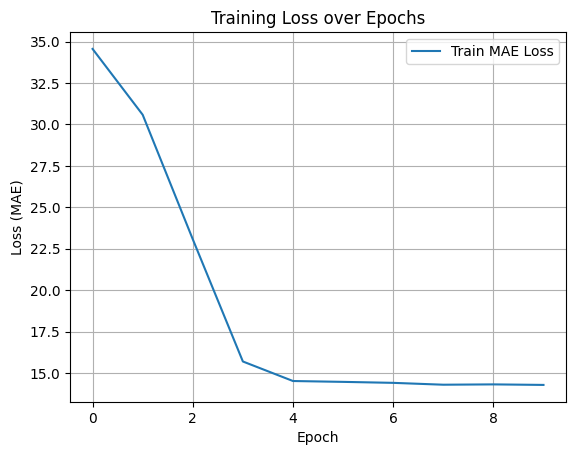

In [74]:
plt.plot(train_losses, label="Train MAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

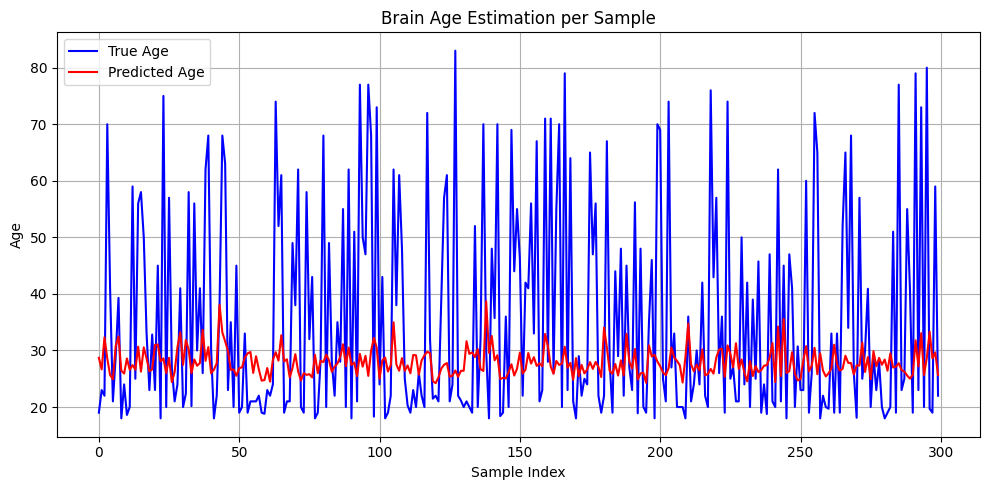

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='True Age', color='blue')
plt.plot(y_pred, label='Predicted Age', color='red')
plt.title("Brain Age Estimation per Sample")
plt.xlabel("Sample Index")
plt.ylabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

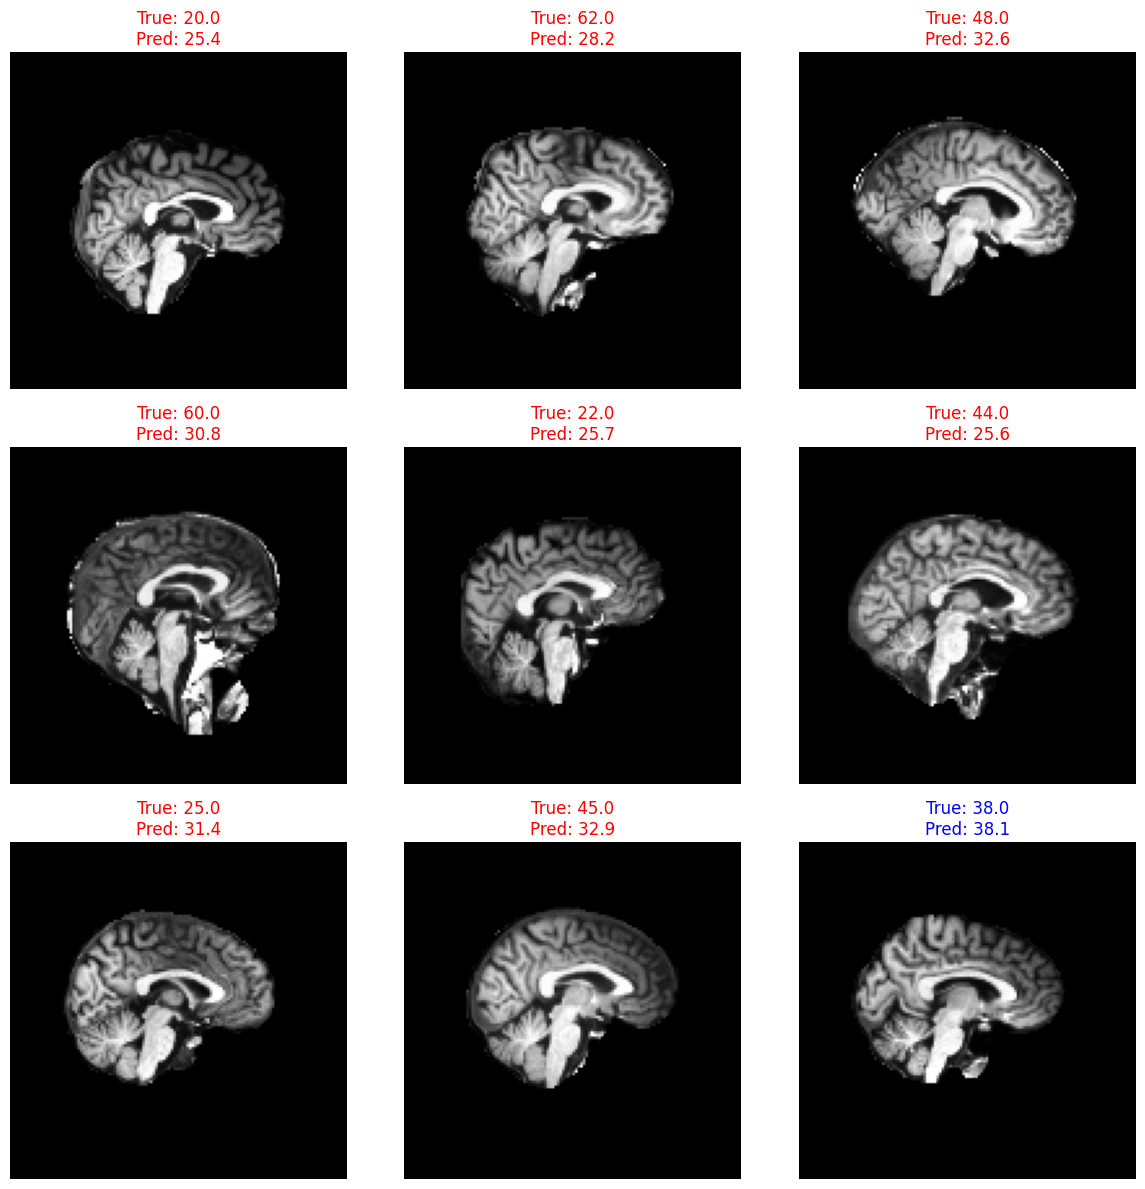

In [76]:
import random

indices = random.sample(range(len(test_ds)), 9)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, idx in enumerate(indices):
    image, true_age = test_ds[idx]
    with torch.no_grad():
        pred_age = model(image.unsqueeze(0).to(device)).item()
    
    error = abs(pred_age - true_age)
    color = 'blue' if error <= threshold else 'red'

    img_np = image.numpy()[0]  # shape: (130, 130, 130)
    middle_slice = img_np[img_np.shape[0] // 2]  # slice giữa trục x

    ax = axs[i // 3, i % 3]
    ax.imshow(middle_slice.T, cmap='gray', origin='lower')
    ax.axis('off')
    ax.set_title(f"True: {true_age:.1f}\nPred: {pred_age:.1f}", color=color)

plt.tight_layout()
plt.show()

# Data

In [1]:
import pandas as pd

df = pd.read_excel("data_processed/participants.xlsx", nrows=1500)
df["image_path"] = df["subject_id"].apply(
    lambda x: f"data_processed/{x}/anat/{x}_T1w_processed.nii.gz"
)

bins = [0, 20, 40, 60, 100]
labels = ["0-20", "21-40", "41-60", "61+"]
df["age_group"] = pd.cut(df["subject_age"], bins=bins, labels=labels)

df

,No.,subject_age,subject_dx,subject_sex,subject_id,dataset_name,image_path,age_group
0,1,44.2,control,m,sub-BrainAge000019,ABIDE/Caltech,data_processed/sub-BrainAge000019/anat/sub-Bra...,41-60
1,2,39.3,control,m,sub-BrainAge000020,ABIDE/Caltech,data_processed/sub-BrainAge000020/anat/sub-Bra...,21-40
2,3,42.5,control,m,sub-BrainAge000021,ABIDE/Caltech,data_processed/sub-BrainAge000021/anat/sub-Bra...,41-60
3,4,19.7,control,m,sub-BrainAge000022,ABIDE/Caltech,data_processed/sub-BrainAge000022/anat/sub-Bra...,0-20
4,5,20.0,control,f,sub-BrainAge000023,ABIDE/Caltech,data_processed/sub-BrainAge000023/anat/sub-Bra...,0-20
...,...,...,...,...,...,...,...,...
1495,1496,23.0,control,f,sub-BrainAge019021,INDI/SALD,data_processed/sub-BrainAge019021/anat/sub-Bra...,21-40
1496,1497,20.0,control,f,sub-BrainAge019022,INDI/SALD,data_processed/sub-BrainAge019022/anat/sub-Bra...,0-20
1497,1498,22.0,control,f,sub-BrainAge019023,INDI/SALD,data_processed/sub-BrainAge019023/anat/sub-Bra...,21-40
1498,1499,23.0,control,m,sub-BrainAge019024,INDI/SALD,data_processed/sub-BrainAge019024/anat/sub-Bra...,21-40


In [2]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['No.', 'subject_age', 'subject_dx', 'subject_sex', 'subject_id', 'dataset_name', 'image_path', 'age_group'],
    num_rows: 1500
})

In [3]:
print("Distribution before splitting:")
print(pd.Series(dataset["age_group"]).value_counts())

Distribution before splitting:
21-40    646
0-20     343
41-60    285
61+      226
Name: count, dtype: int64


In [4]:
dataset[0]

{'No.': 1,
 'subject_age': 44.2,
 'subject_dx': 'control',
 'subject_sex': 'm',
 'subject_id': 'sub-BrainAge000019',
 'dataset_name': 'ABIDE/Caltech',
 'image_path': 'data_processed/sub-BrainAge000019/anat/sub-BrainAge000019_T1w_processed.nii.gz',
 'age_group': '41-60'}

/home/sslab/anaconda3/envs/ntd/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


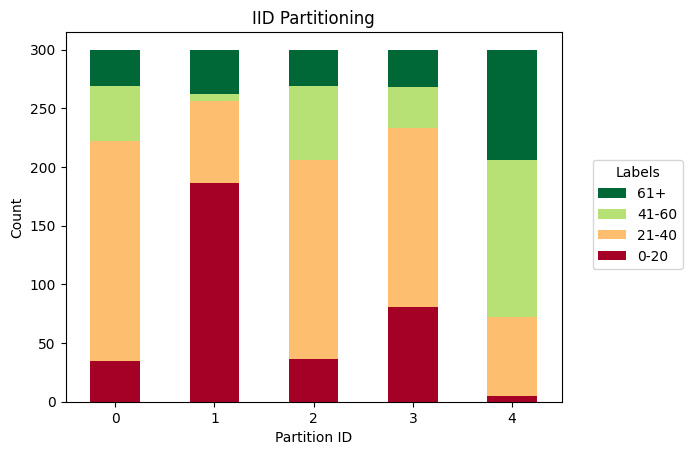

In [ ]:
from flwr_datasets.partitioner import IidPartitioner
from flwr_datasets.visualization import plot_label_distributions
import matplotlib.pyplot as plt

num_clients = 5
iid = IidPartitioner(num_partitions=num_clients)
iid.dataset = dataset

fig, ax, _ = plot_label_distributions(
    iid,
    label_name="age_group",
    plot_type="bar",
    size_unit="absolute",
    legend=True,
    verbose_labels=True,
    title=f"IID Partitioning"
)
plt.show()

/home/sslab/anaconda3/envs/ntd/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


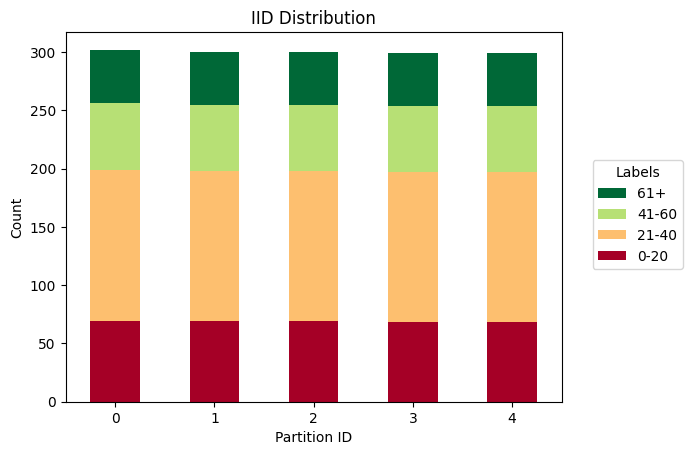

In [5]:
from flwr_datasets.partitioner import PathologicalPartitioner
from flwr_datasets.visualization import plot_label_distributions
import matplotlib.pyplot as plt

num_clients = 5
pathological = PathologicalPartitioner(
    num_partitions=num_clients,
    partition_by="age_group",
    num_classes_per_partition=4,
    class_assignment_mode="random"
)
pathological.dataset = dataset

fig, ax, _ = plot_label_distributions(
    pathological,
    label_name="age_group",
    plot_type="bar",
    size_unit="absolute",
    legend=True,
    verbose_labels=True,
    title=f"IID Distribution"
)
plt.show()

In [7]:
partition0 = pathological.load_partition(0)

In [8]:
partition0

Dataset({
    features: ['No.', 'subject_age', 'subject_dx', 'subject_sex', 'subject_id', 'dataset_name', 'image_path', 'age_group'],
    num_rows: 302
})

In [23]:
class BrainAgeDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Load ảnh MRI
        img = nib.load(sample["image_path"]).get_fdata()

        # Crop ảnh 128x128x128 ở giữa
        d, h, w = img.shape
        crop_size = 128
        start_d = (d - crop_size) // 2
        start_h = (h - crop_size) // 2
        start_w = (w - crop_size) // 2
        img = img[
            start_d:start_d + crop_size,
            start_h:start_h + crop_size,
            start_w:start_w + crop_size
        ]

        # Normalize về [0, 1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, D, H, W]

        return {
            "image": img_tensor,
            "age": torch.tensor(sample["subject_age"], dtype=torch.float32),
            # nếu bạn muốn giữ metadata khác:
            "subject_id": sample["subject_id"],
            "age_group": sample["age_group"]
        }

In [24]:
partition_train_test = partition0.train_test_split(test_size=0.2, seed=42)

In [ ]:
trainset = BrainAgeDataset(partition_train_test["train"])
testset = BrainAgeDataset(partition_train_test["test"])

In [29]:
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=8, pin_memory=True)

In [30]:
print("Số mẫu trong tập train:", len(trainset))
sample = trainset[0]

print("\nCác key trong 1 sample:", sample.keys())

Số mẫu trong tập train: 241

Các key trong 1 sample: dict_keys(['image', 'age', 'subject_id', 'age_group'])


In [31]:
img = sample["image"]
print("Kiểu dữ liệu ảnh:", type(img))
print("Shape ảnh MRI:", img.shape)
print("Min - Max:", img.min().item(), "-", img.max().item())

Kiểu dữ liệu ảnh: <class 'torch.Tensor'>
Shape ảnh MRI: torch.Size([1, 128, 128, 128])
Min - Max: 0.0 - 0.9999998807907104


In [32]:
print("Tuổi thực:", sample["age"].item())
print("Kiểu dữ liệu tuổi:", sample["age"].dtype)

print("ID:", sample["subject_id"])
print("Nhóm tuổi:", sample["age_group"])

Tuổi thực: 45.7400016784668
Kiểu dữ liệu tuổi: torch.float32
ID: sub-BrainAge005472
Nhóm tuổi: 41-60


In [21]:
transformed_partition = partition0.map(get_mri_transforms(), batched=False)

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

In [22]:
sample = transformed_partition[0]
print("Image type:", type(sample["image"]))
print("Image shape:", sample["image"].shape if isinstance(sample["image"], torch.Tensor) else "Not a tensor")

Image type: <class 'list'>
Image shape: Not a tensor


In [20]:
print("Số mẫu sau transform:", len(transformed_partition))
print("\nCấu trúc 1 mẫu:", transformed_partition[0].keys())
print("\nShape ảnh MRI:", transformed_partition[0]["image"].shape)
print("Kiểu dữ liệu ảnh:", transformed_partition[0]["image"].dtype)
print("\nGiá trị tuổi:", transformed_partition[0]["age"])
print("Kiểu dữ liệu tuổi:", transformed_partition[0]["age"].dtype)
print("\nMetadata khác:", {k: v for k, v in transformed_partition[0].items() if k not in ["image", "age"]})

Số mẫu sau transform: 302

Cấu trúc 1 mẫu: dict_keys(['No.', 'subject_age', 'subject_dx', 'subject_sex', 'subject_id', 'dataset_name', 'image_path', 'age_group', 'image', 'age'])


AttributeError: 'list' object has no attribute 'shape'

/home/sslab/anaconda3/envs/ntd/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


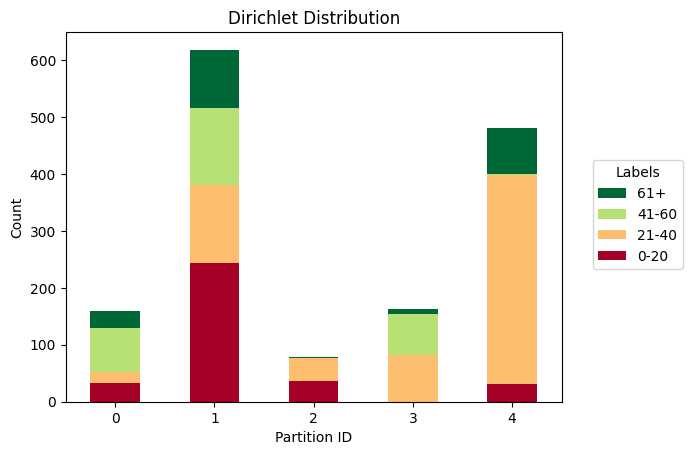

In [17]:
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
import matplotlib.pyplot as plt

num_clients = 5
dirichlet = DirichletPartitioner(
    num_partitions=num_clients,
    partition_by="age_group",
    alpha=0.3,
    seed=42,
    min_partition_size=0,
)
dirichlet.dataset = dataset

fig, ax, _ = plot_label_distributions(
    dirichlet,
    label_name="age_group",
    plot_type="bar",
    size_unit="absolute",
    legend=True,
    verbose_labels=True,
    title=f"Dirichlet Distribution"
)
plt.show()

In [61]:
for i in range(5):
    partition = partitioner.load_partition(i)
    print(f"Client {i}: {len(partition)} samples | "
          f"Avg age: {np.mean(partition['subject_age']):.1f}")

Client 0: 300 samples | Avg age: 38.0
Client 1: 300 samples | Avg age: 37.1
Client 2: 300 samples | Avg age: 29.1
Client 3: 300 samples | Avg age: 34.0
Client 4: 300 samples | Avg age: 40.5


In [9]:
import nibabel as nib

def load_nii(file_path):
    """Đọc file .nii.gz và trả về dữ liệu ảnh"""
    img = nib.load(file_path).get_fdata()
    return img[:, :, img.shape[2] // 2]

# Thêm cột 'image' chứa dữ liệu ảnh
dataset = Dataset.from_pandas(df)
dataset = dataset.map(
    lambda x: {"image": load_nii(x["image_path"])},
    batched=False,
)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [10]:
dataset

Dataset({
    features: ['No.', 'subject_age', 'subject_dx', 'subject_sex', 'subject_id', 'dataset_name', 'image_path', 'image'],
    num_rows: 1500
})

In [18]:
bins = [0, 30, 60, 100]
labels = ["<30", "30-60", ">60"]
dataset = dataset.map(
    lambda x: {"age_group": pd.cut([x["subject_age"]], bins=bins, labels=labels)[0]},
    batched=False,
)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [19]:
dataset

Dataset({
    features: ['No.', 'subject_age', 'subject_dx', 'subject_sex', 'subject_id', 'dataset_name', 'image_path', 'image', 'age_group'],
    num_rows: 1500
})

In [14]:
from flwr_datasets.partitioner import IidPartitioner

partitioner = IidPartitioner(num_partitions=5)
partitioner.dataset = dataset

In [23]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

fds = FederatedDataset(dataset=dataset, partitioners={"my_partition": IidPartitioner(num_partitions=5)})

/home/sslab/anaconda3/envs/ntd/lib/python3.10/site-packages/flwr_datasets/utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: Dataset({
    features: ['No.', 'subject_age', 'subject_dx', 'subject_sex', 'subject_id', 'dataset_name', 'image_path', 'image', 'age_group'],
    num_rows: 1500
}).
  warnings.warn(


In [24]:
partitioner = fds.partitioners["my_partition"]

TypeError: expected str, bytes or os.PathLike object, not Dataset